In [102]:
import numpy as np
from matplotlib.pyplot import figure, draw, pause, gca
from pathlib import Path
import cv2
import scipy.ndimage
import glob
import matplotlib.pyplot as plt
import scipy.ndimage
import regex as re
import scipy.signal
from skimage.metrics import structural_similarity as ssim
import os


In [103]:
def MSE(Img1, Img2):
    error = np.sum((np.array(Img1, dtype=np.float32) - np.array(Img2, dtype=np.float32)) ** 2)
    error = (error/float(Img1.shape[0] * Img1.shape[1]))

    return error

def Image_Comparison(Img1, Img2):

    m = MSE(Img1, Img2)
    s = ssim(Img1, Img2)

    fig = plt.figure()
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(Img1, cmap = plt.cm.gray)
    plt.axis("off")
    plt.title(f'Predicted Image')
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(Img2, cmap = plt.cm.gray)
    plt.axis("off")
    plt.title(f'Given Image Comparison\nMSE: {m:.2f} \n SSIM: {s:.2f}')
    plt.show()
    
def OpticalFlow_Plot(u, v, Inew, scale: int = 3, quivstep: int = 5, fn: Path = None):

    ax = figure().gca()
    ax.imshow(Inew, cmap="gray", origin="lower")
    for i in range(0, u.shape[0], quivstep):
        for j in range(0, v.shape[1], quivstep):
            ax.arrow(j, i, v[i, j] * scale, u[i, j] * scale, color="red", head_width=0.5, head_length=1, )
    if fn:
        ax.set_title(fn)
    draw()

In [104]:
# The function is taken from github and used for frame prediction
def lucas_kanade(Image1, Image2, N, tau=1e-3):
   
    Image1 = Image1 / 255
    Image2 = Image2 / 255
    image_shape = Image1.shape
    half_window_size = N // 2

    kernel_x = np.array([[-1, 1]])
    kernel_y = np.array([[-1], [1]])
    kernel_t = np.array([[1]])

    Ix = scipy.ndimage.convolve(input=Image1, weights=kernel_x, mode="nearest")
    Iy = scipy.ndimage.convolve(input=Image1, weights=kernel_y, mode="nearest")
    It = scipy.ndimage.convolve(input=Image2, weights=kernel_t, mode="nearest") + scipy.ndimage.convolve(input=Image1, weights=-kernel_t, mode="nearest")
    u = np.zeros(image_shape)
    v = np.zeros(image_shape)

    for row_ind in range(half_window_size, image_shape[0] - half_window_size):
        for col_ind in range(half_window_size, image_shape[1] - half_window_size):
            Ix_windowed = Ix[
                row_ind - half_window_size : row_ind + half_window_size + 1,
                col_ind - half_window_size : col_ind + half_window_size + 1,
            ].flatten()
            Iy_windowed = Iy[
                row_ind - half_window_size : row_ind + half_window_size + 1,
                col_ind - half_window_size : col_ind + half_window_size + 1,
            ].flatten()
            It_windowed = It[
                row_ind - half_window_size : row_ind + half_window_size + 1,
                col_ind - half_window_size : col_ind + half_window_size + 1,
            ].flatten()

            A = np.asarray([Ix_windowed, Iy_windowed]).reshape(-1, 2)
            b = np.asarray(It_windowed)

            A_transpose_A = np.transpose(A) @ A

            A_transpose_A_eig_vals, _ = np.linalg.eig(A_transpose_A)
            A_transpose_A_min_eig_val = np.min(A_transpose_A_eig_vals)

            if A_transpose_A_min_eig_val < tau:     # To threshold noise
                continue

            A_transpose_A_PINV = np.linalg.pinv(A_transpose_A)
            w = A_transpose_A_PINV @ np.transpose(A) @ b

            u[row_ind, col_ind], v[row_ind, col_ind] = w

    flow = [u, v]
    I = [Ix, Iy, It]

    return flow, I


In [105]:
# The function is taken from github and used for frame prediction
def compute_gradients(Image1, Image2):

    Image1 = Image1 / 255
    Image2 = Image2 / 255

    kernel_x = np.array([[-1, 1]])
    kernel_y = np.array([[-1], [1]])
    kernel_t = np.array([[1]])

    Ix = scipy.ndimage.convolve(input=Image1, weights=kernel_x, mode="nearest")
    Iy = scipy.ndimage.convolve(input=Image1, weights=kernel_y, mode="nearest")
    It = scipy.ndimage.convolve(input=Image2, weights=kernel_t, mode="nearest") + scipy.ndimage.convolve(
        input=Image1, weights=-kernel_t, mode="nearest"
    )

    I = [Ix, Iy, It]

    return I


def horn_schunck(Image1, Image2, lamda):

    u = np.zeros([Image1.shape[0], Image1.shape[1]])
    v = np.zeros([Image1.shape[0], Image1.shape[1]])

    [Ix, Iy, It] = compute_gradients(Image1, Image2)

    kernel = np.array([[0, 1 / 4, 0], [1 / 4, 0, 1 / 4], [0, 1 / 4, 0]], dtype=np.float32) # Optical flow averaging kernel   

    for _ in range(500):
        u_avg = scipy.ndimage.convolve(input=u, weights=kernel, mode="nearest")
        v_avg = scipy.ndimage.convolve(input=v, weights=kernel, mode="nearest")

        grad = (Ix * u_avg + Iy * v_avg + It) / (lamda ** 2 + Ix ** 2 + Iy ** 2)

        u = u_avg - lamda * Ix * grad
        v = v_avg - lamda * Iy * grad

    flow = [u, v]
    I = [Ix, Iy, It]

    return flow, I


In [106]:
def Next_Frame(secondImage, forward_flow, If, image_ind, dataset, param, algo):

    a, b = forward_flow
    x, y = np.float32(np.meshgrid(np.arange(secondImage.shape[0]), np.arange(secondImage.shape[1])))
    x1, y1 = np.float32(x + a), np.float32(y + b)
    Warp_img = cv2.remap(secondImage, x1, y1, interpolation=cv2.INTER_CUBIC)
    
    return cv2.imread(f"./results/{algo}/{param}/predicted_frames/{dataset}/forward_prediction_{image_ind}.png", flags=cv2.IMREAD_GRAYSCALE)


In [107]:
def Predict_Frame_Sphere(param, algo):

    commands = {
    'lucas_kanade': lucas_kanade,
    'horn_schunck': horn_schunck}

    func = commands[algo]

    images = glob.glob("./input/sphere/*.ppm")
    images.sort(key=lambda f: int(re.sub("\D", "", f)))

    for ind in range(1, len(images) - 3, 2):
        Image1 = cv2.imread(images[ind], flags=cv2.IMREAD_GRAYSCALE)
        Image2 = cv2.imread(images[ind + 1], flags=cv2.IMREAD_GRAYSCALE)
        Image3 = cv2.imread(images[ind + 2], flags=cv2.IMREAD_GRAYSCALE)

        Image1 = np.array(Image1, dtype=np.float32)
        secondImage = np.array(Image2, dtype=np.float32)

        forward_flow, If = func(Image1, secondImage, param)

        Image_Comparison(Next_Frame(Image2, forward_flow, If, ind+2, "sphere", param, algo), Image3)

def Predict_Frame_Corridor(param, algo):
    commands = {
    'lucas_kanade': lucas_kanade,
    'horn_schunck': horn_schunck}

    func = commands[algo]

    images = glob.glob("./input/corridor/*.pgm")
    images.sort(key=lambda f: int(re.sub("\D", "", f)))

    for ind in range(1, len(images) - 2, 2):
        Image1 = cv2.imread(images[ind], flags=cv2.IMREAD_GRAYSCALE)
        Image2 = cv2.imread(images[ind + 1], flags=cv2.IMREAD_GRAYSCALE)
        Image3 = cv2.imread(images[ind + 2], flags=cv2.IMREAD_GRAYSCALE)

        Image1 = np.array(Image1, dtype=np.float32)
        Image2 = np.array(Image2, dtype=np.float32)
        
        forward_flow, If = func(Image1, Image2, param)

        Image_Comparison(Next_Frame(Image2, forward_flow, If, ind+2, "corridor", param, algo), Image3)

Lucas Kanade


window size = 4



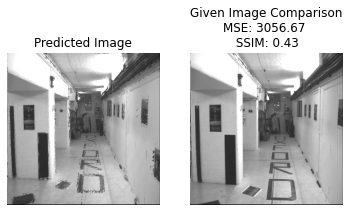

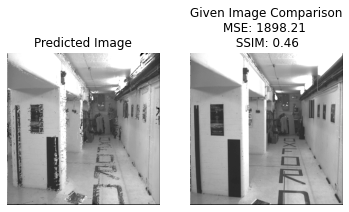

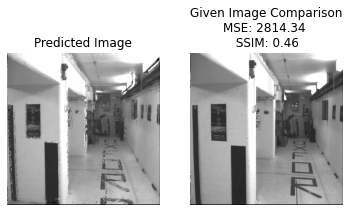

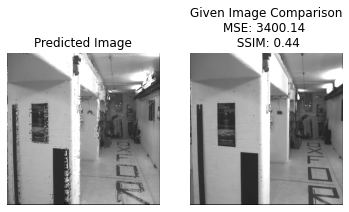

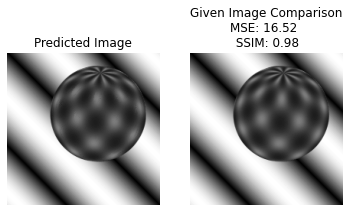

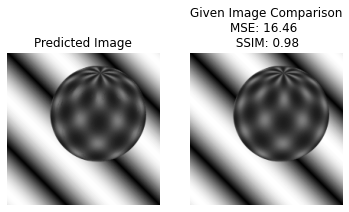

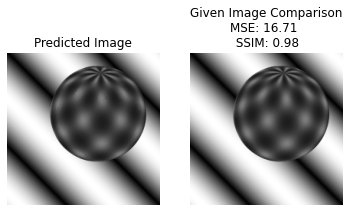

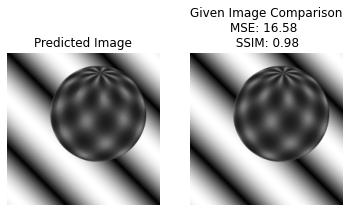

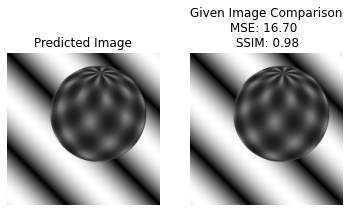

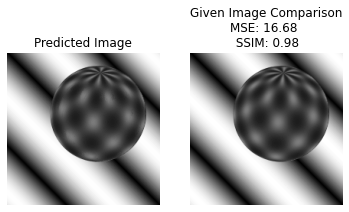

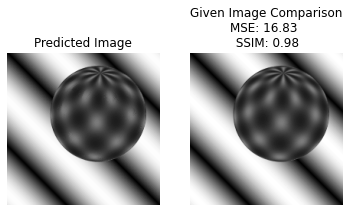

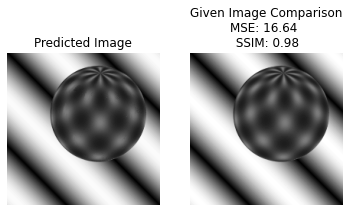


window size = 9



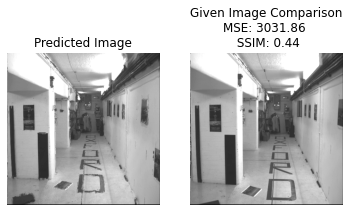

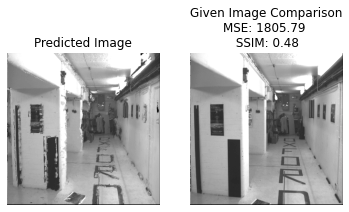

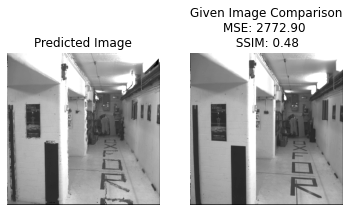

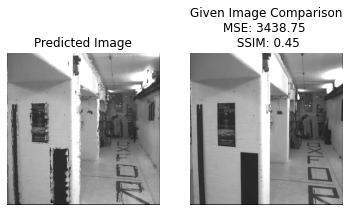

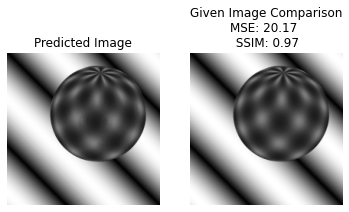

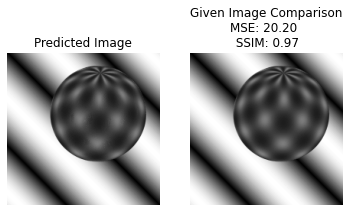

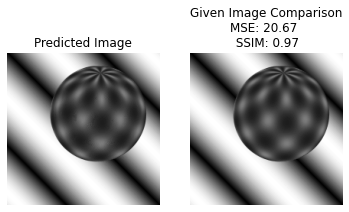

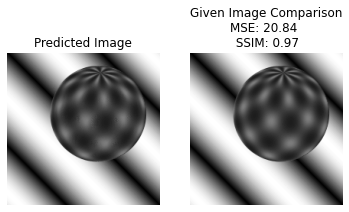

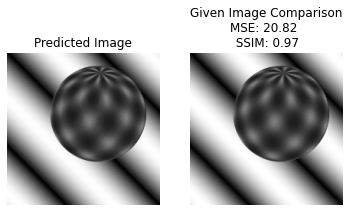

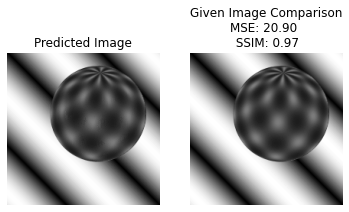

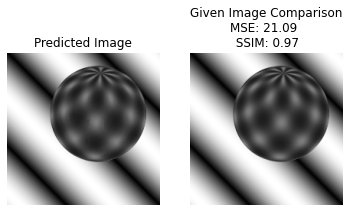

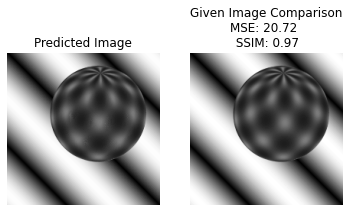


window size = 12



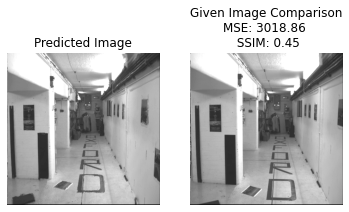

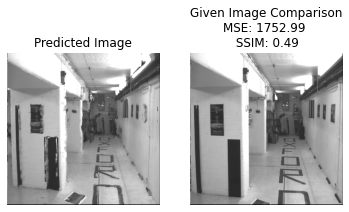

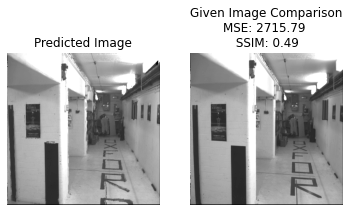

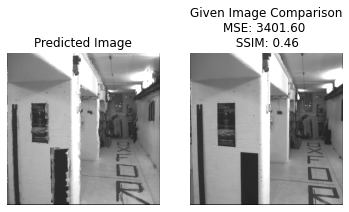

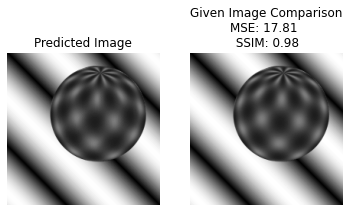

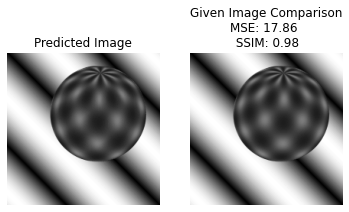

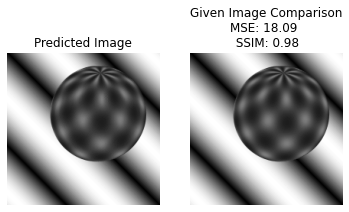

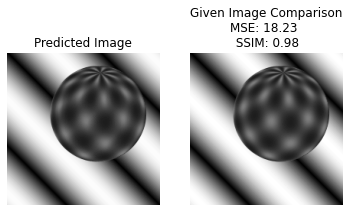

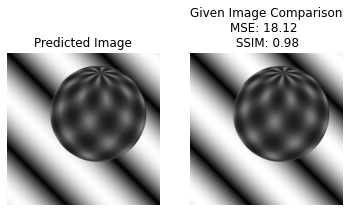

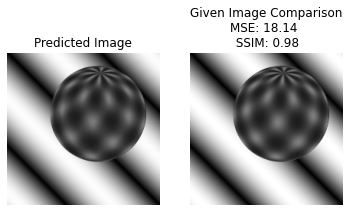

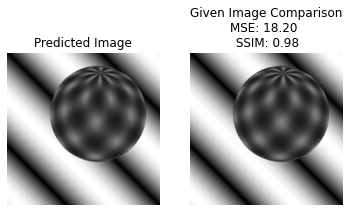

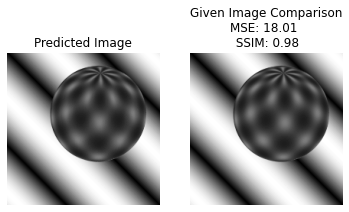


window size = 18



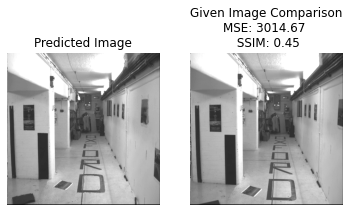

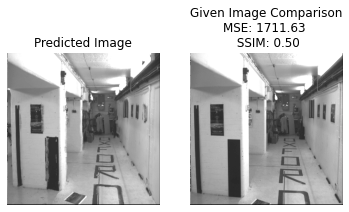

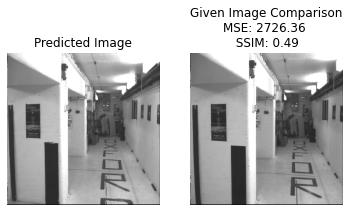

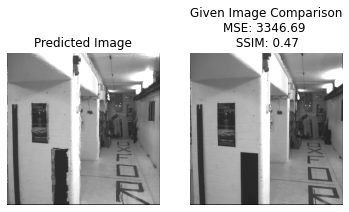

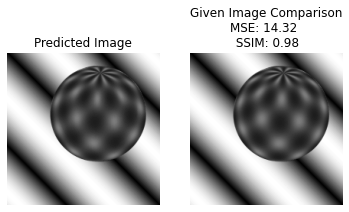

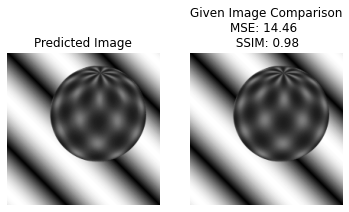

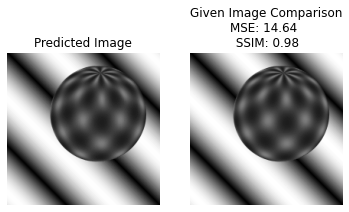

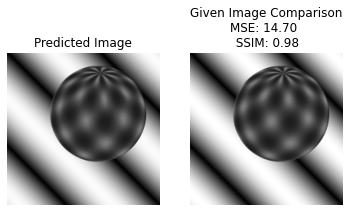

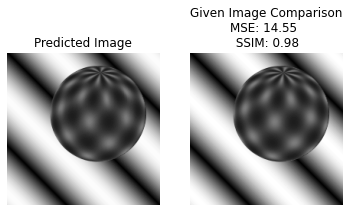

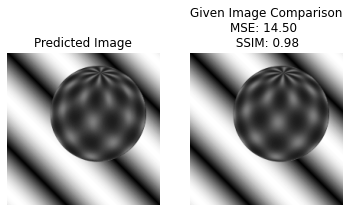

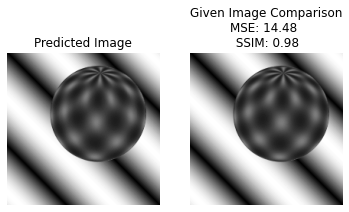

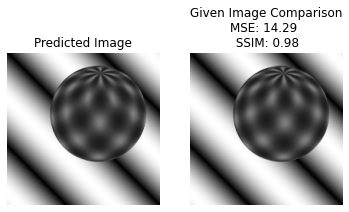

In [108]:
print('Lucas Kanade\n')
for window in [4, 9, 12, 18]:
    print(f'\nwindow size = {window}\n')
    Predict_Frame_Corridor(window, 'lucas_kanade')
    Predict_Frame_Sphere(window, 'lucas_kanade')

Horn Schunck


lambda = 0.15



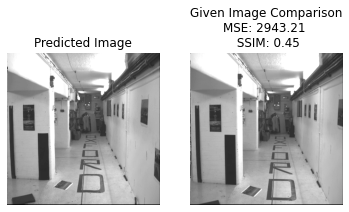

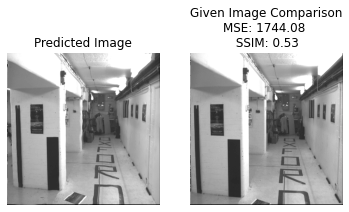

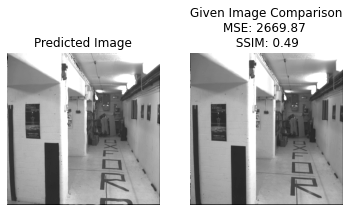

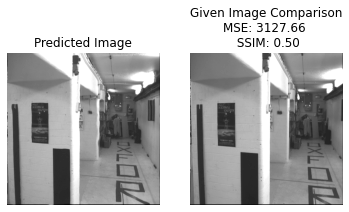

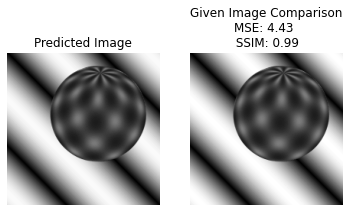

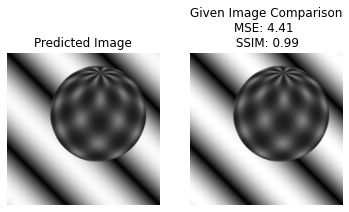

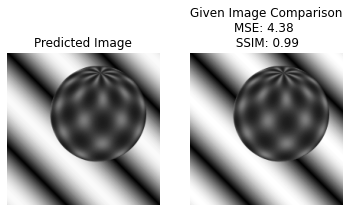

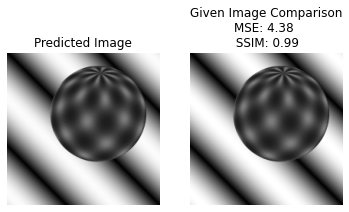

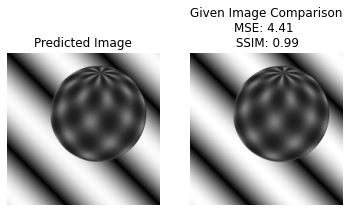

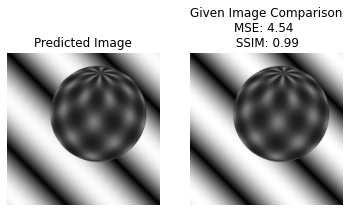

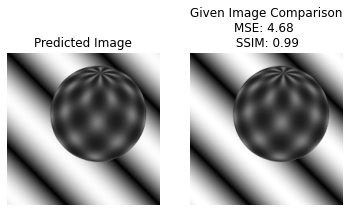

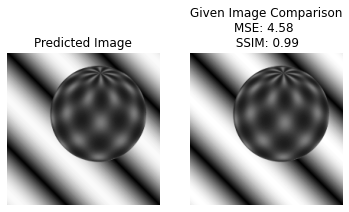


lambda = 0.32



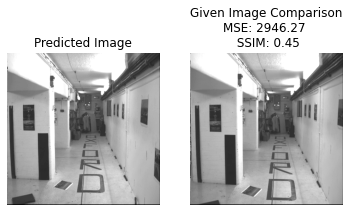

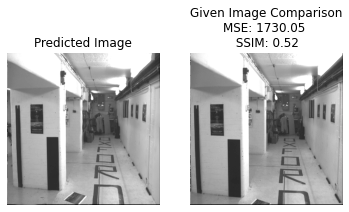

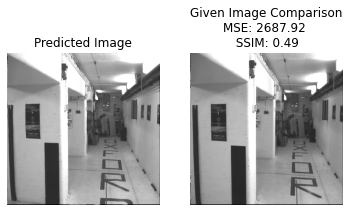

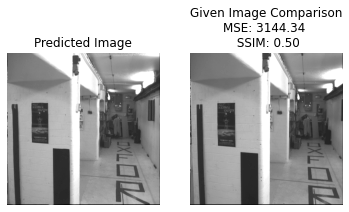

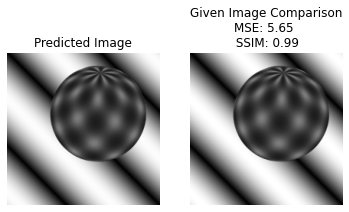

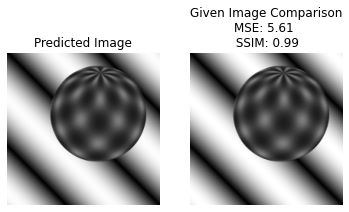

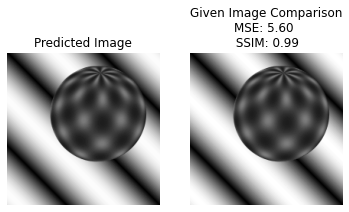

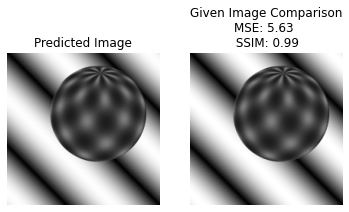

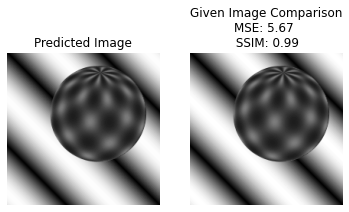

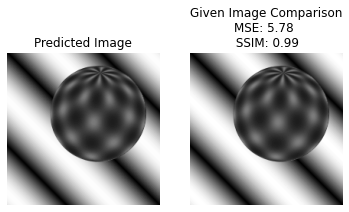

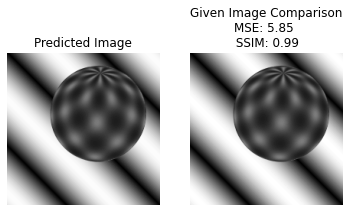

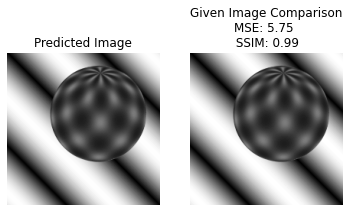


lambda = 0.65



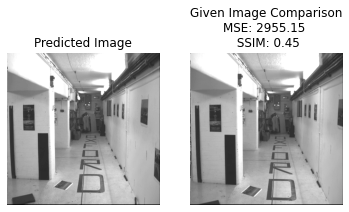

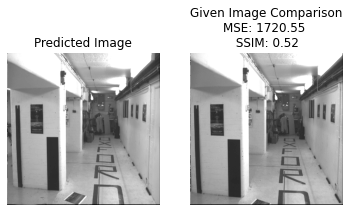

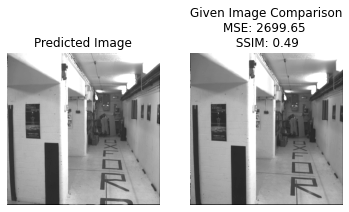

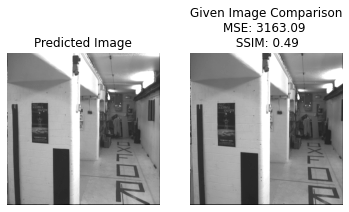

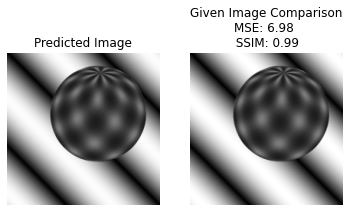

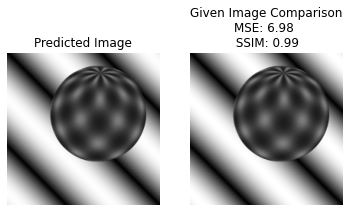

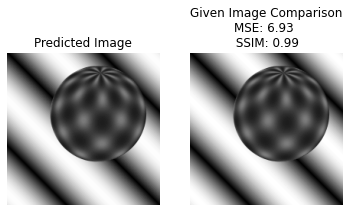

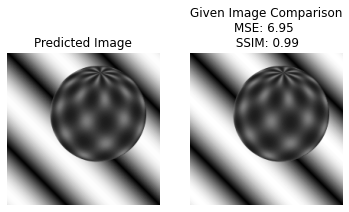

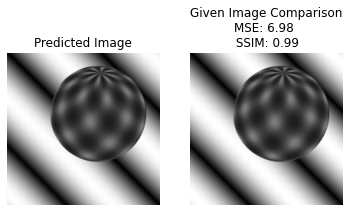

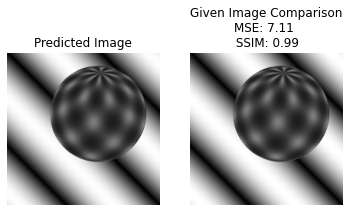

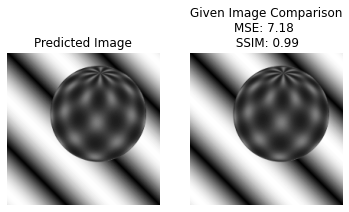

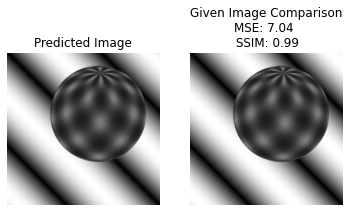


lambda = 1



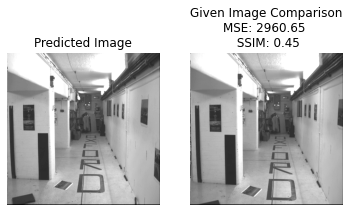

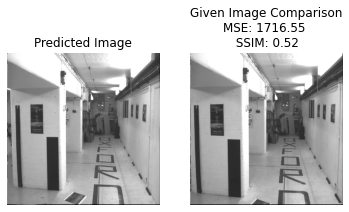

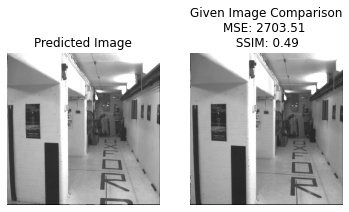

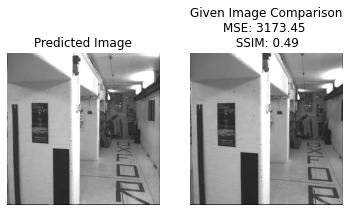

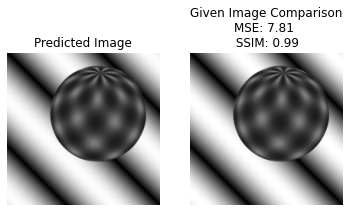

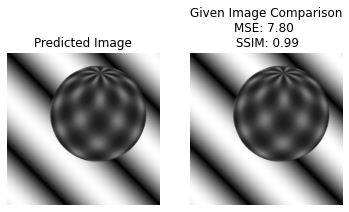

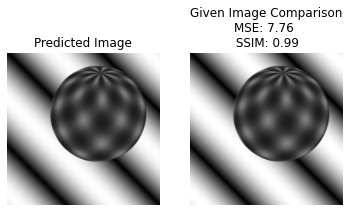

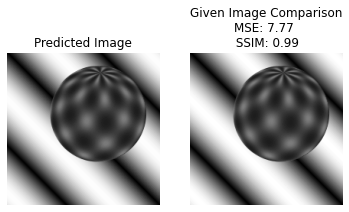

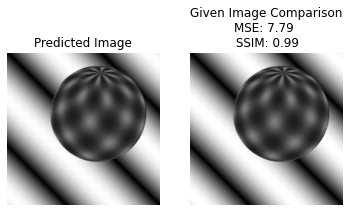

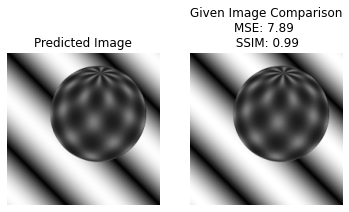

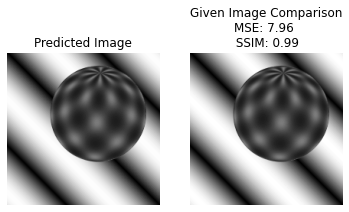

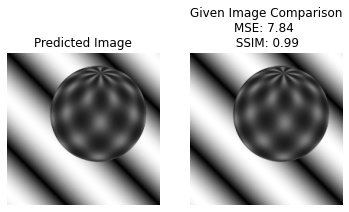


lambda = 5



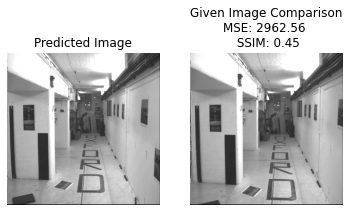

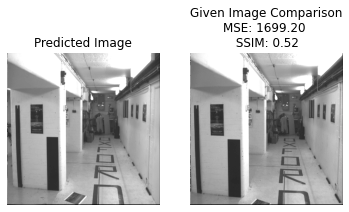

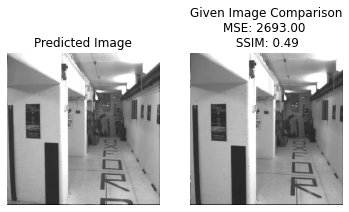

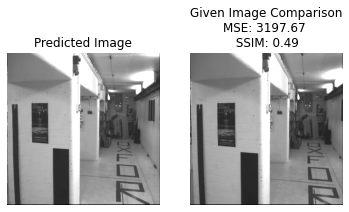

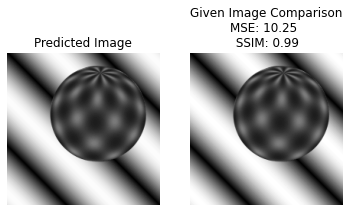

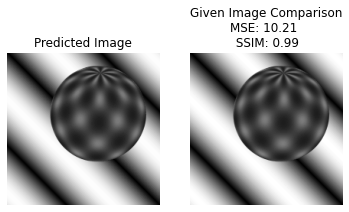

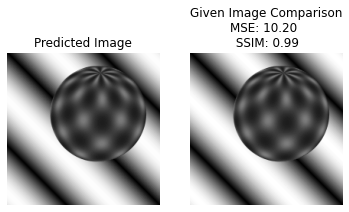

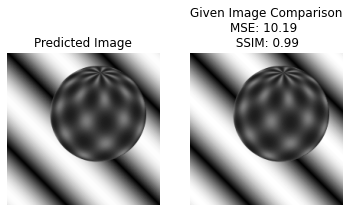

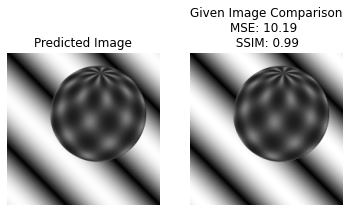

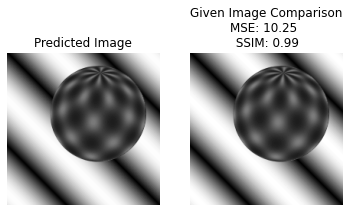

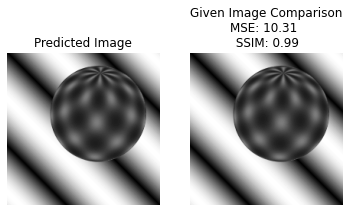

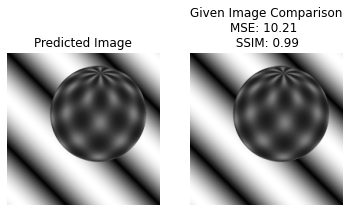

In [109]:
print('Horn Schunck\n')
for lamda in [0.15, 0.32, 0.65, 1, 5]:
    print(f'\nlambda = {lamda}\n')
    Predict_Frame_Corridor(lamda, 'horn_schunck')
    Predict_Frame_Sphere(lamda, 'horn_schunck')